In [1]:
import os
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles, MolToSmiles, MolToSmarts, MolFromSmarts
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
from guacamol.guacamol.common_scoring_functions_iktos import MaxTanimotoScoringFunction
from rdkit.Chem.Scaffolds import MurckoScaffold as ms
from synthetic_scorers.RSPred.predictorRS import RSPredictor
from synthetic_scorers.RScore.RScore_calculation import interact_with_api, get_RScore
import numpy as np
import time
from add_scores_to_db import add_score_to_db_pi3kmtor

In [63]:
os.environ["MONGO_URL"] = ""
os.environ["DB_STORAGE"] = ""
os.environ["SPAYA_API_URL"] = ""
os.environ["SPAYA_API_TOKEN"] = ""

In [39]:
mongo_url = os.getenv("MONGO_URL")
db_storage = os.getenv("DB_STORAGE")
url_spaya_api = os.getenv("SPAYA_API_URL")
token_spaya_api = os.getenv("SPAYA_API_TOKEN")

In [40]:
client = MongoClient(mongo_url)
DB = client[db_storage]

# PI3KMTOR Generation 4 targets


## Evolution reward (and other scores)

In [41]:
save = False

In [23]:
list_collection = ["pi3kmtor_1", "pi3kmtorSAscore_1","pi3kmtorSCscore_1", "pi3kmtorRAscore_1","pi3kmtorRScore_1","pi3kmtorRSPred_1"]

In [43]:
results = {}
n_molecules_list = []
n_distinct_list = []
for db_name in list_collection :
    df = pd.DataFrame(list(DB[db_name].find({}))) 
    if "pi3k" not in df:
        add_score_to_db_pi3kmtor(db_name)
        df = pd.DataFrame(list(DB[db_name].find({}))) 

    results[db_name] = df
    n_molecules_list.append(len(results[db_name])
                           )
    n_distinct_list.append(len(results[db_name].smiles.unique()))
    print(db_name, len(results[db_name]), len(results[db_name].smiles.unique()))

pi3kmtor_1 80399 16085
pi3kmtorSAscore_1 78612 12775
pi3kmtorSCscore_1 80291 14635
pi3kmtorRAscore_1 80663 14509
pi3kmtorRScore_1 83215 11081
pi3kmtorRSPred_1 79861 12703


In [44]:
targets_per_col = {
    "pi3k":7, 
    "mTor":8.5,
    "qed":0.5, 
    "simi":0.5}

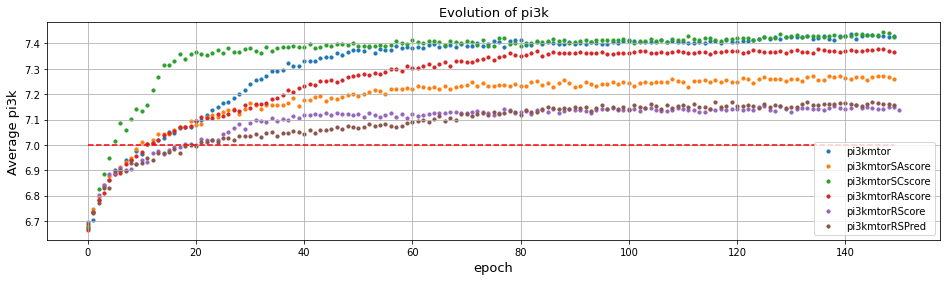

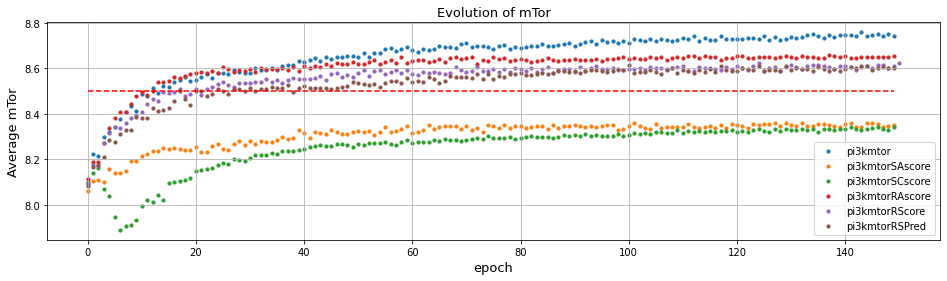

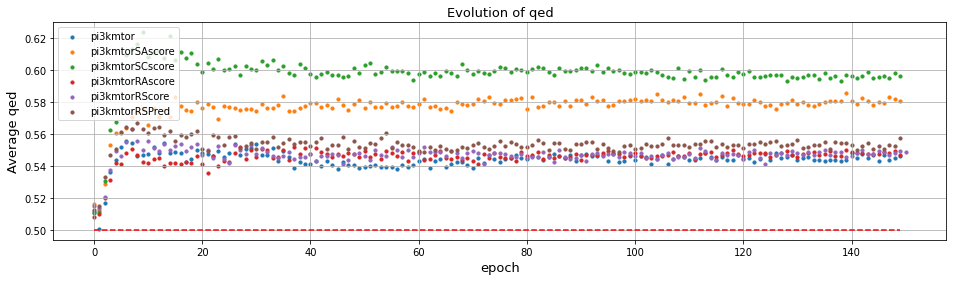

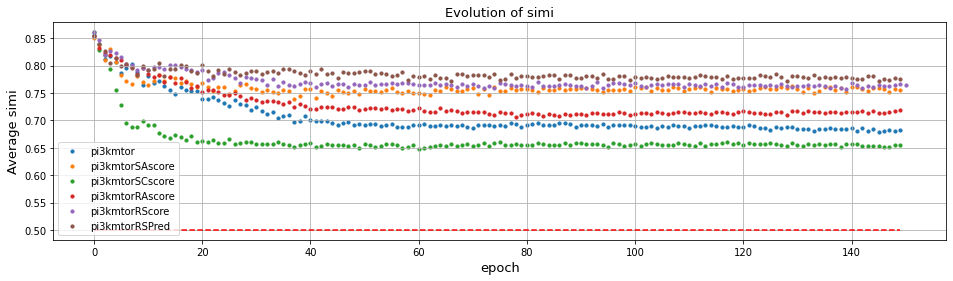

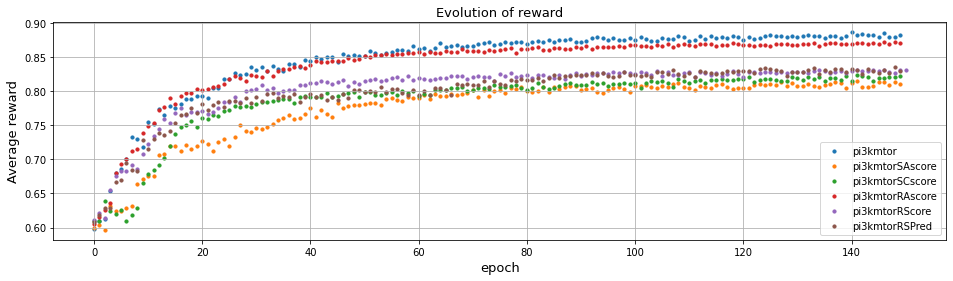

In [45]:
col_to_eval = ['pi3k', 'mTor', 'qed','simi', 'reward']
for col in col_to_eval:
    plt.figure(figsize=(16,4))
    list_evolutions = {}
    for key, doc in results.items():
        evolution = doc.groupby(by="epoch").mean()[col]
        plt.scatter(range(len(evolution)), evolution ,s=10, label=key[:-2])

    if col in targets_per_col :
        plt.hlines(targets_per_col[col], xmin=0, xmax=149,color="red", linestyles="dashed")

    plt.xlabel("epoch", fontsize=13)
    plt.ylabel("Average "+col,fontsize=13)
    plt.title("Evolution of "+col,fontsize=13)

    plt.grid()
    plt.legend()
    if save:
        plt.savefig("results_data/evolution_pi3k_"+col+".png")
    else:
        plt.show()

## Molecules in the blueprint

In [46]:
query = {"pi3k":{"$gt":7},
         "mTor":{"$gt":8.5}, 
         "qed":{"$gt":0.5}, 
         "simi": {"$gt":0.5}, 
         "epoch":{"$lt":150},
        }

In [47]:
def add_spaya_info_to_dataset(df):
    results = pd.DataFrame(interact_with_api(df.smiles.to_list()[:], timeout=3))
    if len(results[results.status != "DONE"])>0:
        print("Molecules in blueprint not all scored")
        print("Status of scoring : ",results.status.value_counts())
        return df
    print("All molecules scored with RScore")
    results = results[results.status=="DONE"]
    results.rscore.fillna(0)
    results = results[["smiles","rscore"]]
    results.columns = ["smiles","RScore_3mn"]
    df_all = df.merge(results, on="smiles",how="right")
    return df_all

In [51]:
predictor = RSPredictor()
results_blueprint = {}
for db_name in list_collection:
    print("DB NAME", db_name)
    if os.path.exists("results_data/results_blueprint_"+db_name+".csv"):
        in_blueprint = pd.read_csv("results_data/results_blueprint_"+db_name+".csv", index_col=0)
    else:
        in_blueprint = pd.DataFrame(list(DB[db_name].find(query))).drop_duplicates(subset="smiles")
        try:
            in_blueprint = add_spaya_info_to_dataset(in_blueprint)
        except:
            print("It seems that you don't have access to the SpayaAPI for the scoring with RScore")
        in_blueprint["RSPred"] = predictor.predict_many(in_blueprint.smiles.to_list())
        in_blueprint.to_csv("results_data/results_blueprint_"+db_name+".csv")
        
    print("{} molecules in the blueprint. ".format(len(in_blueprint)))
    results_blueprint[db_name] = in_blueprint

DB NAME pi3kmtor_1
4996 molecules in the blueprint. 
DB NAME pi3kmtorSAscore_1
290 molecules in the blueprint. 
DB NAME pi3kmtorSCscore_1
194 molecules in the blueprint. 
DB NAME pi3kmtorRAscore_1
3859 molecules in the blueprint. 
DB NAME pi3kmtorRScore_1
850 molecules in the blueprint. 
DB NAME pi3kmtorRSPred_1
985 molecules in the blueprint. 


In [52]:
print("How many molecules are specific to each generation ? \n ")
for key_1 in results_blueprint.keys():
    all_molec = set()
    for key, val in results_blueprint.items():
        if key == key_1:
            continue
        smiles_generated = val.smiles.to_list()
        all_molec.update(set(smiles_generated ))
    tmp = results_blueprint[key_1]
    tmp = tmp[tmp.RScore_3mn>=0.5]
    n_specific = len(tmp[~tmp.smiles.isin(all_molec)])
    print("{} molecules for {} generation".format(n_specific, key_1))

How many molecules are specific to each generation ? 
 
67 molecules for pi3kmtor_1 generation
126 molecules for pi3kmtorSAscore_1 generation
74 molecules for pi3kmtorSCscore_1 generation
94 molecules for pi3kmtorRAscore_1 generation
382 molecules for pi3kmtorRScore_1 generation
357 molecules for pi3kmtorRSPred_1 generation


### Get the results of generations 
- Always the same 2 molecules from ground truth are found 
- We are curious about the diversity of the molecules found. We can look at the most similar from the quadran and see the coverage of those.

In [53]:
pi3k_all = pd.read_csv("../pi3kmtor/all_pi3k.csv", index_col = 0)
pi3kmtor_cadran = pd.read_csv("../pi3kmtor/pi3k_cadran.csv", index_col=0) 
tanimoto_scorer = MaxTanimotoScoringFunction(smiles_ref = pi3kmtor_cadran.smiles.to_list(), fp_type="ECFP4")

In [54]:
def compute_standard_murcko(mol):
    return ms.GetScaffoldForMol(mol)

def compute_generic_murcko(mol):
    return ms.MakeScaffoldGeneric(compute_standard_murcko(mol))

def add_dist_to_gt(df):
    df.loc[:, "quadran_most_simi"] = df.loc[:, "smiles"].apply(lambda x : tanimoto_scorer.score_mol(MolFromSmiles(x),return_smiles=True))
    df.loc[:, "max_simi"] = df.loc[:, "smiles"].apply(lambda x : tanimoto_scorer.score_mol(MolFromSmiles(x), return_smiles=False))
    return df

In [55]:
cols = ["In blueprint", "Recovered from GT", "Most simi coverage", "Average simi w GT",
        "Standard murcko", "Generic murcko", "Average RSCore", "# Feasible", "# RScore > 0.4","mse RSPred", "corr RSPred",
        "std murkco good RScore", "Gene murcko good RScore", "most simi cov good RScore", "ave simi gt good RScore",
       ]

results_comparison = pd.DataFrame(columns = cols)

In [56]:
def compute_row(results_df):
    results_df = add_dist_to_gt(results_df)
    all_standard_murcko = list(set([MolToSmarts(compute_standard_murcko(MolFromSmiles(s))) for s in results_df.smiles.to_list()]))
    all_generic_murcko = list(set([MolToSmarts(compute_generic_murcko(MolFromSmiles(s))) for s in results_df.smiles.to_list()]))
    N_recovered =  len(results_df[results_df.max_simi==1].quadran_most_simi.unique())
    most_simi_cov = len(results_df.quadran_most_simi.unique())
    ave_simi_gt =  round(results_df.max_simi.mean(),2)
    good_RScore = results_df[results_df.RScore_3mn>=0.5]
    
    all_std_murcko_good_RScore = len(list(set([MolToSmarts(compute_standard_murcko(MolFromSmiles(s))) for s in good_RScore.smiles.to_list()])))
    all_gene_murcko_good_RScore = len(list(set([MolToSmarts(compute_generic_murcko(MolFromSmiles(s))) for s in good_RScore.smiles.to_list()])))
    most_simi_cov_good_RScore = len(good_RScore.quadran_most_simi.unique())
    ave_simi_gt_good_RScore =  round(good_RScore.max_simi.mean(),2)
    mse_RSPred = ((results_df.RScore_3mn - results_df.RSPred)**2).mean()
    corr_RSPred = np.corrcoef(results_df.RScore_3mn, results_df.RSPred)[0,1]
    row = [len(results_df), N_recovered, most_simi_cov, ave_simi_gt, len(all_standard_murcko), len(all_generic_murcko) , round(results_df.RScore_3mn.mean(),2), len(results_df[results_df.RScore_3mn>0]),  len(good_RScore), mse_RSPred, corr_RSPred ]
    row.extend([all_std_murcko_good_RScore, all_gene_murcko_good_RScore, most_simi_cov_good_RScore, ave_simi_gt_good_RScore])
    return row

In [57]:
for key, val in results_blueprint.items():
    results_comparison.loc[key[:-2]] = compute_row(val)

In [58]:
list_columns =["In blueprint", "Recovered from GT", "Most simi coverage", "Average simi w GT",
        "Standard murcko", "Generic murcko", "Average RSCore", "# Feasible", "# RScore > 0.4"]

if save:
    results_comparison[list_columns].to_csv("results_data/diversity_molecules_in_blueprint.csv")
       

In [2]:
results_comparison = pd.read_csv("results_data/diversity_molecules_in_blueprint.csv", index_col=0)


In [3]:
list_columns_good_RScore = ["# RScore > 0.4",
        "std murkco good RScore", "Gene murcko good RScore", "most simi cov good RScore", "ave simi gt good RScore"]
if save:
       results_comparison[list_columns_good_RScore].to_csv("results_data/diversity_molecules_in_blueprint_good_RScore.csv")

results_comparison[list_columns_good_RScore]

NameError: name 'save' is not defined

In [4]:
list_gen = ["pi3kmtor","pi3kmtorRAscore", "pi3kmtorSCscore" ,"pi3kmtorSAscore", "pi3kmtorRScore", "pi3kmtorRSPred"]
table_RScore_selection = pd.DataFrame(index=["classic", "RAscore","SCscore","SAscore", "RScore","RSPred"])
table_RScore_selection["Bad RS (0)"] = (results_comparison.loc[list_gen, "In blueprint"] - results_comparison.loc[list_gen, "# Feasible"]).to_list()
table_RScore_selection["Medium RS (<0.5)"] = (results_comparison.loc[list_gen, "# Feasible"] - results_comparison.loc[list_gen,  "# RScore > 0.4"]).to_list()
table_RScore_selection["Good RS"] = results_comparison.loc[list_gen, "# RScore > 0.4"].to_list()

In [16]:
table_RScore_selection.index = 

Index(['classic', 'RAscore', 'SCscore', 'SAscore', 'RScore', 'RSPred'], dtype='object')

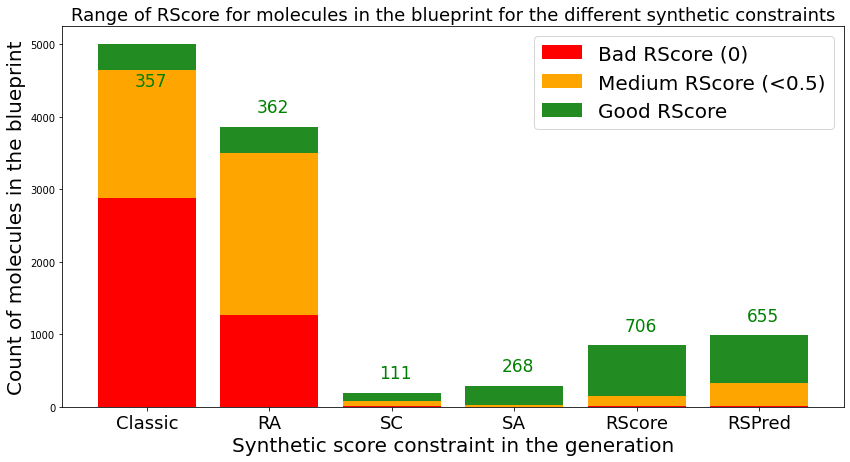

In [22]:
save =True
plt.figure(figsize=(14, 7))
           
plt.bar(["Classic", "RA", "SC", "SA", "RScore", "RSPred"], height  = table_RScore_selection["Bad RS (0)"], color="red", label = "Bad RScore (0)")
plt.bar(["Classic", "RA", "SC", "SA", "RScore", "RSPred"], height  = table_RScore_selection["Medium RS (<0.5)"], bottom =  table_RScore_selection["Bad RS (0)"], color="orange", label = "Medium RScore (<0.5)")
plt.bar(["Classic", "RA", "SC", "SA", "RScore", "RSPred"], height  = table_RScore_selection["Good RS"], bottom =  table_RScore_selection["Bad RS (0)"]+table_RScore_selection["Medium RS (<0.5)"], color="forestgreen", label = "Good RScore")
plt.legend(fontsize=20)

for i, v in enumerate(table_RScore_selection["Good RS"]):
    alt = table_RScore_selection.iloc[i].sum()
    if i ==0:
        alt = alt-770
    plt.text(i-0.1, alt+200, str(int(v)), color='green',fontsize=17)

plt.title("Range of RScore for molecules in the blueprint for the different synthetic constraints",fontsize=18)
plt.xlabel("Synthetic score constraint in the generation", fontsize=20)
plt.ylabel("Count of molecules in the blueprint", fontsize=20)
plt.xticks(fontsize=18)
if save:
    plt.savefig("results_data/ComparisonRScoreOfSelection_all_bigger.png", dpi=300)
else:
    plt.show()